In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

for dirname, _, filesnames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
electronics_data = pd.read_csv("/users/syy19/ratings_Electronics (1).csv", names = ['userID', 'productID', 'Rating', 'timestamp'])

In [3]:
# Display the data
electronics_data.head()

,userID,productID,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [4]:
# Shape of the data
electronics_data.shape

(7824482, 4)

In [5]:
# Taking subset of the dataset
electronics_data = electronics_data.iloc[:1048576, 0:]

In [6]:
# Check the datatypes
electronics_data.dtypes

userID        object
productID     object
Rating       float64
timestamp      int64
dtype: object

In [7]:
electronics_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userID     1048576 non-null  object 
 1   productID  1048576 non-null  object 
 2   Rating     1048576 non-null  float64
 3   timestamp  1048576 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 32.0+ MB


In [8]:
# Five point summary
electronics_data.describe()['Rating'].T

count    1.048576e+06
mean     3.973380e+00
std      1.399329e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [9]:
# Find the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_data.Rating.min()))
print('Maximum rating is: %d' %(electronics_data.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


In [10]:
# Check for missing values
print('Number of missing values across columns: \n', electronics_data.isnull().sum())

Number of missing values across columns: 
 userID       0
productID    0
Rating       0
timestamp    0
dtype: int64


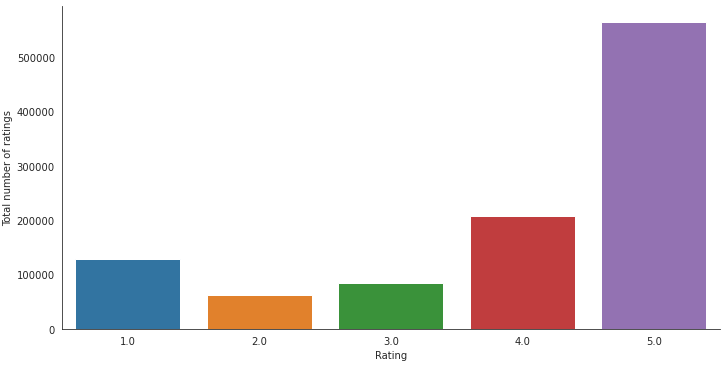

In [11]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data = electronics_data, aspect = 2.0, kind = 'count')
    g.set_ylabels("Total number of ratings")

In [12]:
print("Total data ")
print("-" * 50)
print("n\Total No of ratings :", electronics_data.shape[0])
print("Total No of users :", len(np.unique(electronics_data.userID)))
print("Total No of products :",len(np.unique(electronics_data.productID)))

Total data 
--------------------------------------------------
n\Total No of ratings : 1048576
Total No of users : 786330
Total No of products : 61894


In [13]:
# Dropping the Timestamp column
electronics_data.drop(['timestamp'], axis = 1, inplace = True)

In [14]:
# Analysis of rating given by the user
no_of_rated_products_per_user = electronics_data.groupby(by = 'userID')['Rating'].count().sort_values(ascending = False)
no_of_rated_products_per_user.head()

userID
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: Rating, dtype: int64

In [15]:
no_of_rated_products_per_user.describe()

count    786330.000000
mean          1.333506
std           1.385612
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         412.000000
Name: Rating, dtype: float64

In [16]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation = 'higher')

<Figure size 720x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the qantile')

<Figure size 720x720 with 0 Axes>

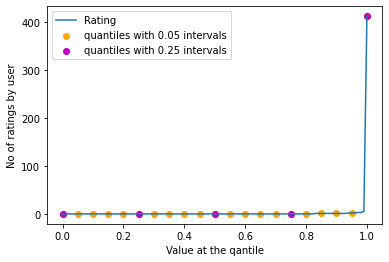

In [17]:
plt.figure(figsize = (10, 10))
plt.figure("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x = quantiles.index[::5], y = quantiles.values[::5], c = 'orange', label = "quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x = quantiles.index[::25], y = quantiles.values [::25], c = 'm', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the qantile')
plt.legend(loc = 'best')
plt.show()

In [18]:
print ('\n No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)))


 No of rated product more than 50 per user : 38



In [19]:
# Getting the new datafram which contains users who has given 50 or more ratings
new_df = electronics_data.groupby("productID").filter(lambda x: x['Rating'].count() >= 50)

Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[Text(-500.0, 0, ''),
 Text(0.0, 0, ''),
 Text(500.0, 0, ''),
 Text(1000.0, 0, ''),
 Text(1500.0, 0, ''),
 Text(2000.0, 0, ''),
 Text(2500.0, 0, ''),
 Text(3000.0, 0, ''),
 Text(3500.0, 0, ''),
 Text(4000.0, 0, ''),
 Text(4500.0, 0, '')]

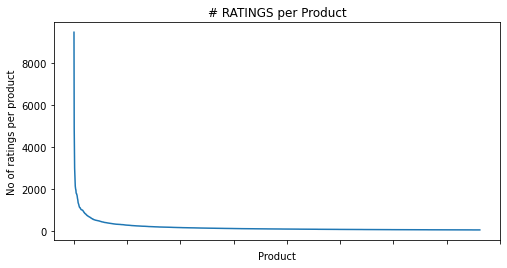

In [20]:
no_of_ratings_per_product = new_df.groupby(by = 'productID')['Rating'].count().sort_values(ascending = False)

fig = plt.figure(figsize = plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [21]:
# Average Rating of the product
new_df.groupby('productID')['Rating'].mean().head()

productID
0972683275    4.470980
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
Name: Rating, dtype: float64

In [22]:
new_df.groupby('productID')['Rating'].mean().sort_values(ascending = False).head()

productID
B0000DYV9H    4.947368
B000053HC5    4.945783
B00009R96C    4.885714
B00005LE76    4.879310
B000I1X3W8    4.869565
Name: Rating, dtype: float64

In [23]:
# Total no of rating for product
new_df.groupby('productID')['Rating'].count().sort_values(ascending = False).head()

productID
B0002L5R78    9487
B0001FTVEK    5345
B000I68BD4    4903
B000BQ7GW8    4275
B00007E7JU    3523
Name: Rating, dtype: int64

In [24]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productID')['Rating'].mean())

In [25]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productID')['Rating'].count())

In [26]:
ratings_mean_count.head()

,Rating,rating_counts
productID,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171


In [27]:
ratings_mean_count['rating_counts'].max()

9487

<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

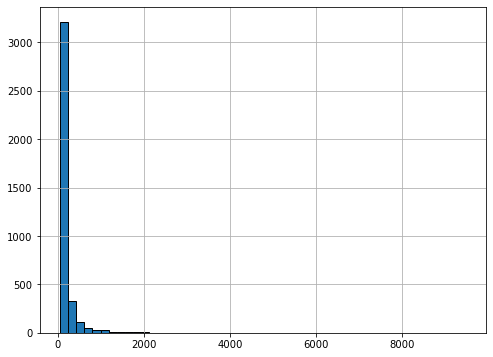

In [28]:
plt.figure(figsize = (8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins = 50)

<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

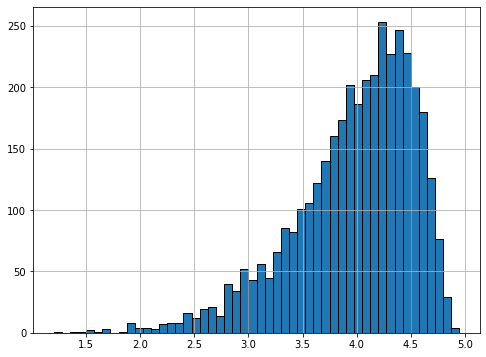

In [29]:
plt.figure(figsize = (8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Rating'].hist(bins = 50)

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

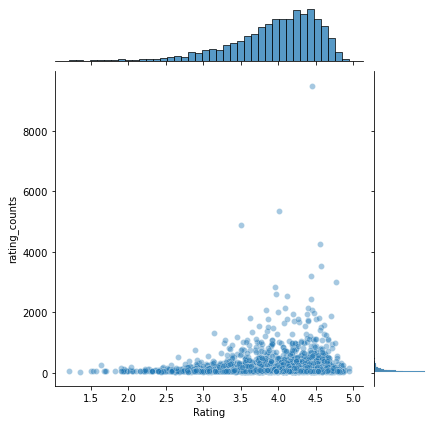

In [30]:
plt.figure(figsize = (8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x = 'Rating', y = 'rating_counts', data = ratings_mean_count, alpha = 0.4)

<AxesSubplot:xlabel='productID'>

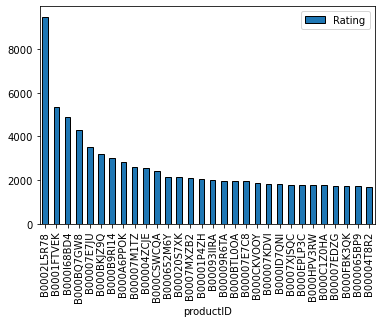

In [31]:
popular_products = pd.DataFrame(new_df.groupby('productID')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending = False)
most_popular.head(30).plot(kind = "bar")

In [69]:
from surprise import KNNWithMeans
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
sns.set_style('darkgrid')
from collections import defaultdict

In [33]:
# Reading the dataset
reader = Reader(rating_scale = (1, 5))
data = Dataset.load_from_df(new_df, reader)

In [34]:
# Splitting the dataset
trainset, testset = train_test_split(data, test_size = 0.3, random_state = 10)

In [67]:
# Use Item_Based KNNWithMeans
knn = KNNWithMeans(k = 5, sim_options = {'name': 'pearson_baseline', 'user_based': False})
knn.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [64]:
# run the trained model against the testset
test_pred_knn = knn.test(testset)
test_pred_knn

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


[Prediction(uid='A2CTXDLXKOHCEH', iid='B00003CWDH', r_ui=5.0, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='ABGCDODB3OLPE', iid='B0002D6QJO', r_ui=3.0, est=3.0, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='AIL0HKZRRCE3L', iid='B00097CUIE', r_ui=5.0, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='AQ2SRQCX77658', iid='B000FVDD30', r_ui=5.0, est=4.987762655642762, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid='AQR9NP6PBTSPT', iid='B00007LTBA', r_ui=1.0, est=1, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='AXOY9UHP9HJNX', iid='B0002L5R78', r_ui=5.0, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='AKLRRKLW8NYRO', iid='B0002344GG', r_ui=1.0, est=1, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A5ZY4LIO5D2Q9', iid='B0001PFQAI', r_ui=5.0, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A21R77ZGM42X

In [65]:
# get RMSE
print("Item_based Model: Test Set")
accuracy.rmse(test_pred_knn, verbose = True)

Item_based Model: Test Set
RMSE: 0.0099


0.009854889950007042

In [35]:
# Use SVD
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'test_rmse': array([1.27566212, 1.26676456, 1.27084115, 1.27092848, 1.2690276 ]),
 'test_mae': array([1.001369  , 0.99466066, 0.99939328, 0.99858329, 0.9968665 ]),
 'fit_time': (75.67872190475464,
  70.10505509376526,
  61.893638610839844,
  60.59634876251221,
  70.78652954101562),
 'test_time': (3.6439149379730225,
  2.5045676231384277,
  2.0478315353393555,
  2.2277274131774902,
  3.104841709136963)}

In [68]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [62]:
# get RMSE
print("Item_based Model: Test Set")
accuracy.rmse(test_pred_svd, verbose = True)

Item_based Model: Test Set
RMSE: 0.7046


0.704600287204914

In [85]:
df_user = new_df[(new_df['userID'] == 'AT6CZDCP4TRGA') & (new_df['Rating'] == 5)]
print(df_user)
drop_list = df_user['productID']

               userID   productID  Rating
122966  AT6CZDCP4TRGA  B00005T3Q2     5.0
333829  AT6CZDCP4TRGA  B0000C20T5     5.0
471577  AT6CZDCP4TRGA  B0002INUIY     5.0
525337  AT6CZDCP4TRGA  B0002ZPJZY     5.0
632049  AT6CZDCP4TRGA  B0007XOHTU     5.0
638754  AT6CZDCP4TRGA  B00080DSEM     5.0
659128  AT6CZDCP4TRGA  B0009E1YPM     5.0
835813  AT6CZDCP4TRGA  B000E6G9RI     5.0
907123  AT6CZDCP4TRGA  B000F4C2AM     5.0


In [78]:
user = ratings_mean_count.copy()
user = user.reset_index()

In [86]:
user['Estimate_Score'] = user['productID'].apply(lambda x: knn.predict('AT6CZDCP4TRGA', x).est)

user = user.sort_values('Estimate_Score', ascending = False)

user = user[~user['productID'].isin(drop_list)]

print(user.head(10))

       productID    Rating  rating_counts  Estimate_Score
3612  B000HAOVGM  4.524535            591             5.0
2956  B000E1FYQA  4.005376            372             5.0
1260  B0000UV2AW  4.178862            246             5.0
3335  B000FDTNZK  3.789683            252             5.0
3704  B000HZ9CCA  4.077225            764             5.0
1056  B00009W3TY  3.876506            332             5.0
2158  B0007N55NW  4.088608            711             5.0
444   B00005UKBD  4.858974             78             5.0
3287  B000F7JCRA  4.243056            432             5.0
917   B000092YPR  3.907534            876             5.0


In [79]:
user['Estimate_Score'] = user['productID'].apply(lambda x: svd.predict('AT6CZDCP4TRGA', x).est)

user = user.sort_values('Estimate_Score', ascending = False)
print(user.head(10))

       productID    Rating  rating_counts  Estimate_Score
2426  B0009N5MCY  4.460526            304        4.366128
1661  B0002EQU6C  4.716578            187        4.275313
3488  B000GABCY2  4.180812            271        4.267906
3551  B000GT5FK0  4.650224            223        4.259118
613   B00006B9CR  3.876950            577        4.252017
2985  B000E6G9RI  3.649592           1347        4.178890
1714  B0002J226O  4.528736             87        4.166926
3786  B000I97N4O  4.385027            187        4.116683
969   B00009R6FV  4.763158             76        4.087147
746   B00007056H  4.192918            819        4.080401


In [41]:
new_df1 = new_df.head(10000)
ratings_matrix = new_df1.pivot_table(values = 'Rating', index = 'userID', columns = 'productID', fill_value = 0)
ratings_matrix.head()

productID,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
userID,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0266076X6KPZ6CCHGVS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0571176384K8RBNKGF8O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
ratings_matrix.shape

(9832, 76)

In [43]:
X = ratings_matrix.T
X.head()

userID,A01852072Z7B68UHLI5UG,A0266076X6KPZ6CCHGVS,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0571176384K8RBNKGF8O,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A0821988FXKFYX53V4QG,A099626739FNCRNHIKBCG,...,AZWOPBY75SGAM,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXKUK895VGSM,AZXP46IB63PU8,AZYTSU42BZ7TP,AZZGJ2KMWB7R,AZZMV5VT9W7Y8,AZZST8OYL5P4Q
productID,,,,,,,,,,,,,,,,,,,,,
0972683275,0,0,5,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501520,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
1400501776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1400532620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
X.shape

(76, 9832)

In [45]:
X1 = X

In [46]:
# Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components = 10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(76, 10)

In [47]:
# Correlation Matrix
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(76, 76)

In [48]:
X.index[75]

'B00000K135'

In [49]:
i = "B00000K135"
product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

75

In [50]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(76,)

In [51]:
Recommend = list(X.index[correlation_product_ID > 0.65])

#Removes the item alreday bought by the customer
Recommend.remove(i)

Recommend[0:24]

['1400599997',
 '6301977173',
 '9983891212',
 'B00000J1EJ',
 'B00000J1EQ',
 'B00000J1F3',
 'B00000J1TX',
 'B00000J1V3',
 'B00000J3NF',
 'B00000J4EY',
 'B00000J4GE',
 'B00000JCTO',
 'B00000JFMK']